You need this to read files from Google Drive


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
pd.options.display.max_rows = 60
pd.options.display.min_rows = None

### Training / Test Data
Data is from https://github.com/marcoortu/jira-social-repository . This is from the paper "The Jira Repository Dataset" by Marco Ortu et al - see https://www.researchgate.net/publication/301370380_The_JIRA_Repository_Dataset 

In [0]:
dataset = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Octopus2/JIRA_OPEN_DATA_ZOOKEEPER.csv")

Data data was imported to a PostgreSQL DB and used this SQL query to obtain the csv: 
`select * from jira_issue_report where status = 'Closed' and type = 'Bug' and project = 'ZOOKEEPER' not (description is null or description = '') and priority is not null `
---
The reason for this is the assumption that if a bug is Closed, most likely the priority is most likely assigned correctly



In [0]:
dataset.head()

id                  created  ... assignee_id reporter_id
0  16037  2011-06-16 22:07:44.375  ...      7832.0        7832
1  16615  2009-08-07 08:57:50.287  ...      7750.0        7829
2  16189  2010-11-20 06:12:26.124  ...      8219.0        8219
3  16616   2009-08-07 06:11:42.25  ...      7750.0        7750
4  16934  2008-10-07 04:50:15.001  ...      7750.0        7827

[5 rows x 18 columns]

Looking at the data, the 2 candidate columns to be used as features for classification are "title" and "description". The column to use as target for training would be "priority". 

However if you look at "title", the number of words may too little to be used for feature engineering. One way is to concat the 'title' with 'description' so that the features are richer. 

In [0]:
dataset.describe()

id       votes    watchers  assignee_id  reporter_id
count    447.000000  447.000000  447.000000   432.000000   447.000000
mean   16532.789709    0.044743    0.456376  7893.532407  7915.689038
std      342.555125    0.255457    1.040545   386.292454   514.016322
min    15801.000000    0.000000    0.000000   744.000000   744.000000
25%    16286.500000    0.000000    0.000000  7818.000000  7818.000000
50%    16576.000000    0.000000    0.000000  7827.000000  7827.000000
75%    16813.000000    0.000000    1.000000  7953.750000  8126.000000
max    17110.000000    3.000000   11.000000  8385.000000  8385.000000

In [0]:
dataset.dtypes

id                  int64
created            object
description        object
key                object
priority           object
project            object
project_name       object
repositoryname     object
resolution         object
resolved           object
status             object
title              object
type               object
updated            object
votes               int64
watchers            int64
assignee_id       float64
reporter_id         int64
dtype: object

In [0]:
dataset.columns

Index(['id', 'created', 'description', 'key', 'priority', 'project',
       'project_name', 'repositoryname', 'resolution', 'resolved', 'status',
       'title', 'type', 'updated', 'votes', 'watchers', 'assignee_id',
       'reporter_id'],
      dtype='object')

In [0]:
df = dataset[["title", "description", "priority"]]

In [0]:
df.head()

title  ... priority
0  Quota is not correctly rehydrated on snapshot ...  ...  Blocker
1  bookkeeper create calls completion too many times  ...    Major
2           test -e not available on solaris /bin/sh  ...    Major
3                    CnxManagerTest failed on hudson  ...    Major
4                                          FLE test.  ...    Major

[5 rows x 3 columns]

Merge the 'title' and 'description' into a column called 'features'

In [0]:
df['features'] = df['title'] + df['description']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df.head()

title  ...                                           features
0  Quota is not correctly rehydrated on snapshot ...  ...  Quota is not correctly rehydrated on snapshot ...
1  bookkeeper create calls completion too many times  ...  bookkeeper create calls completion too many ti...
2           test -e not available on solaris /bin/sh  ...  test -e not available on solaris /bin/shtest -...
3                    CnxManagerTest failed on hudson  ...  CnxManagerTest failed on hudsonIt timed out ac...
4                                          FLE test.  ...       FLE test.fast leader election test failing .

[5 rows x 4 columns]

In [0]:
df.shape

(447, 4)

Trying a very very basic approach to classifying to see if it will do a decent classification. This is following the example from https://textblob.readthedocs.io/en/dev/classifiers.html

In [0]:
import random
from textblob.classifiers import NaiveBayesClassifier
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
random.seed(1)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df.features, df.priority, test_size=0.2)

Textblob needs training and test data as lists of tuples

In [0]:
train_set = list(map(lambda x, y:(x,y), X_train, Y_train))
test_set = list(map(lambda x, y:(x,y), X_test, Y_test))

In [0]:
cl = NaiveBayesClassifier(train_set)

In [0]:
cl.accuracy(test_set)

0.4888888888888889

Not very good accuracy: a little better than a coin toss

Ok see if we can remove noise from the description column

In [0]:
df1 = df.copy()

Inspect a few lines just to get a feel of the data

In [0]:
pd.set_option('max_colwidth', 400)

In [0]:
df1[1:10].features

1                                                               bookkeeper create calls completion too many timeswhen calling the asynchronous version of create, the completion routine is called more than once.
2                              test -e not available on solaris /bin/shtest -e FILENAME is not support on /bin/sh in solaris. This is used in bin/zkEnv.sh. We can substitute test -f FILENAME. Attaching a patch.
3    CnxManagerTest failed on hudsonIt timed out according to the console output:http://hudson.zones.apache.org/hudson/job/ZooKeeper-trunk/406/testReport/org.apache.zookeeper.test/CnxManagerTest/testCnxManager/
4                                                                                                                                                                     FLE test.fast leader election test failing .
5     In two places, the wrong class is specified for the loggerCopy and paste strikes again.  In two logger instantiations, the wrong class is passed to th

In [0]:
df1.features = df1.features.str.replace(r"[\n\r\t]+", " ")

In [0]:
df1[1:20].features

1                                                                                                                                                                                                                                                                  bookkeeper create calls completion too many timeswhen calling the asynchronous version of create, the completion routine is called more than once.
2                                                                                                                                                                                                                                 test -e not available on solaris /bin/shtest -e FILENAME is not support on /bin/sh in solaris. This is used in bin/zkEnv.sh. We can substitute test -f FILENAME. Attaching a patch.
3                                                                                                                                                                                           

In [0]:
df1[21:40].features

21    testEarlyLeaderAbandonment failing intermittently, quorum formed, no serving.Looks pretty serious - quorum is formed but no clients can attach. Will attach logs momentarily.This test was introduced in the following commit (all three jira commit at once):ZOOKEEPER-335. zookeeper servers should commit the new leader txn to their logs.ZOOKEEPER-1081. modify leader/follower code to correctly deal ...
22    Multi deserialization issuesFrom the mailing list:FileTxnSnapLog.restore contains a code block handling a NODEEXISTS failure during deserialization. The problem is explained there in a code comment. The code block however is only executed for a CREATE txn, not for a multiTxn containing a CREATE.Even if the mentioned code block would also be executed for multi transactions, it needs adaption fo...
23    problems with read only mode, intermittent test failures and ERRORs in the logI'm having a lot problems testing the 3.4.0 release candidate (0). I'm seeing frequent failures in RO un

Removing all email addrs and URLs

In [0]:
df1.features = df1.features.str.replace(r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})", " ")
df1.features = df1.features.str.replace(r"((http[s]?|ftp):\/)?\/?([^:\/\s]+)((\/\w+)*\/)([\w\-\.]+[^#?\s]+)(.*)?(#[\w\-]+)?", " ")

In [0]:
df1[41:60].features

41    Data inconsistency when the node(s) with the highest zxid is not present at the time of leader electionIf a participant with the highest zxid (lets call it A) isn't present during leader election, a participant with a lower zxid (say B) might be chosen as a leader. When A comes up, it will replay the log with that higher zxid. The change that was in that higher zxid will only be visible to the...
42                                                           Exceptions thrown from handleAuthentication can cause buffer corruption issues in NIOServerExceptions thrown by an AuthenticationProvider's handleAuthentication method will not be caught, and can cause the buffers in the NIOServer to not read requests fully or properly. Any exceptions thrown here should be caught and treated as auth failure. 
43                                                                                                                                                                                          

In [0]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(df1.features, df1.priority, test_size=0.2)

textblob classifier needs training and test datasets as lists of tuples (text, target) 

In [0]:
train_set1 = list(map(lambda x, y:(x,y), X_train1, Y_train1))
test_set1 = list(map(lambda x, y:(x,y), X_test1, Y_test1))

In [0]:
cl = NaiveBayesClassifier(train_set1)
cl.accuracy(test_set1)

0.4666666666666667

Not much improvement

Ok let's see if we can do some kind of word analysis

In [0]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
# remove all the junk and just extract the words
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df1.features)

In [0]:
text_counts.shape

(447, 3574)

In [0]:
text_counts.toarray()
print(cv.get_feature_names())

['0', '00', '000', '001', '009', '01', '010d', '02', '03', '04', '05', '06', '07', '072', '073', '08', '09', '0aclversion', '0ephemeralowner', '0numchildren', '0the', '0x', '0x0', '0x000000302af71900', '0x000000383fc30215', '0x00007f5d7bb5bbe4', '0x00012fwe', '0x0datalength', '0x1d819cversion', '0x298d3b1fa90000', '0x3', '0x321b16868f40003', '0x3f5180de91', '0x4021c42', '0x40786cc', '0x5047b42', '0x5047ef6', '0x52276d1d5161350', '0x5302c4403a30232', '0x5ctime', '0x5e66e950', '0x5mtime', '0x6', '0x6bd4f8', '0x806a21b', '0x806c6bf', '0x807fdca', '0x808043a', '0xfffffffffffffffe', '1', '10', '100', '1009', '100k', '100msec', '101', '102', '1022', '1030', '1030zookeeper', '1033', '1042', '10467', '105', '108', '1081', '1083', '10bug', '10bytes', '10k', '11', '111', '114', '115', '11741', '1180', '12', '120', '120710dataversion', '122', '124', '126', '127', '12788', '128', '13', '130', '131', '135', '136', '14', '14001', '15', '1508', '155', '157', '16', '161', '166', '168', '17', '1775', '

In [0]:
cv1 = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1),min_df=2)
text_counts1 = cv1.fit_transform(df1.features)

In [0]:
text_counts1.shape

(447, 1288)

In [0]:
text_counts1.toarray()
print(cv1.get_feature_names())

['00', '03', '04', '05', '06', '07', '08', '0xfffffffffffffffe', '10', '100', '100k', '11', '114', '115', '12', '127', '13', '131', '14', '15', '16', '17', '18', '19', '20', '2000', '2009', '2010', '2011', '21', '2181', '22', '23', '243', '25', '255', '28', '2827', '29', '36', '3rd', '41', '48', '481', '50', '55', '60', '64', '65', '73', '74', '740', '756', '76', '94', 'able', 'abort', 'ac', 'accept', 'access', 'accessive', 'according', 'acl', 'acls', 'action', 'actual', 'actually', 'add', 'added', 'adding', 'address', 'addresses', 'adds', 'admin', 'advances', 'affect', 'affects', 'allocated', 'allow', 'allowing', 'allows', 'ant', 'apache', 'api', 'apparently', 'appears', 'append', 'application', 'applied', 'applies', 'appropriate', 'argument', 'arguments', 'array', 'arraylist', 'artifact', 'artifacts', 'assertion', 'assertionfailederror', 'assumes', 'async', 'asynchammertest', 'asynchronous', 'atleast', 'attach', 'attached', 'attaching', 'attachment', 'attempt', 'attempts', 'attribute

Remove all the numbers and only pick those strings that only show up at least on 2 rows in the dataset. Tried overwriting the tokenizer in the CountVectorizer

In [0]:
token2 = RegexpTokenizer(r'[^0-9]+')
cv2 = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1),tokenizer = token2.tokenize, min_df=2)
text_counts2 = cv2.fit_transform(df1.features)

In [0]:
text_counts2.shape

(447, 33)

In [0]:
text_counts2.toarray()
print(cv2.get_feature_names())

[' ', '  ', '   ', ' - info  [nioservercxn.factory: ', ' [pool-', " completes then the zkwatcher process event method will clear the watch and the subsequent operation's (", ' is processed on the client (zookeeper.java, zkwatcher) after ', ' zxid:', ')', ')     [java] java result: ', ') delete("node"...)if watch events for ', ') event will be ignored', ') exists("node", a)', ') getdata("node", a)', ') setdata("node"...)', ')==', '){noformat}', ',', '-', '-thread-', '.', '. ', ':', ': ', '=', '==    at ', '==    by ', 'b', 'c', 'd', 'f', 'x', 'zookeeper-']


Result is not so good. Decided to just remove the numbers and use the default tokenizer 

In [0]:
df1.features = df1.features.str.replace(r"([0-9]+)", " ")

In [0]:
cv3 = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), min_df=2)
text_counts3 = cv3.fit_transform(df1.features)
print(text_counts3.shape)
text_counts3.toarray()
print(cv3.get_feature_names())

(447, 1240)
['able', 'abort', 'ac', 'accept', 'access', 'accessive', 'according', 'acl', 'acls', 'action', 'actual', 'actually', 'add', 'added', 'adding', 'address', 'addresses', 'adds', 'admin', 'advances', 'affect', 'affects', 'allocated', 'allow', 'allowing', 'allows', 'ant', 'apache', 'api', 'apparently', 'appears', 'append', 'application', 'applied', 'applies', 'appropriate', 'argument', 'arguments', 'array', 'arraylist', 'artifact', 'artifacts', 'assertion', 'assertionfailederror', 'assumes', 'async', 'asynchammertest', 'asynchronous', 'atleast', 'attach', 'attached', 'attaching', 'attachment', 'attempt', 'attempts', 'attribute', 'audit', 'auth', 'authenticate', 'authenticated', 'authentication', 'authinfo', 'automatically', 'autoreconf', 'available', 'avoid', 'away', 'bad', 'barrier', 'based', 'basic', 'beginning', 'behavior', 'believe', 'believes', 'better', 'big', 'bin', 'binaryinputarchive', 'binding', 'bindings', 'bit', 'blindly', 'block', 'blocking', 'blocks', 'bookeeper', 

Much better

In [0]:
text_counts3.shape

(447, 1171)

Ok not too large. I want to expand it to include bi-grams 

In [0]:
cv4 = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,2), min_df=2)
text_counts4 = cv4.fit_transform(df1.description)
text_counts4.toarray()
print(cv4.get_feature_names())

['able', 'ac', 'accept', 'access', 'accessive', 'accessive jar', 'according', 'acl', 'action', 'actual', 'actual log', 'actually', 'add', 'add tests', 'added', 'added zookeeper', 'adding', 'additionally', 'address', 'addresses', 'addresses colon', 'adds', 'advances', 'affect', 'affects', 'allocated', 'allow', 'allowing', 'allows', 'ant', 'ant package', 'ant test', 'apache', 'apache bookkeeper', 'apache jute', 'apache zookeeper', 'api', 'api does', 'apparently', 'appears', 'append', 'append stringbuilder', 'application', 'application calls', 'applies', 'appropriate', 'argument', 'arguments', 'array', 'artifact', 'assertion', 'assertionfailederror', 'assume', 'assumes', 'async', 'asynchammertest', 'asynchronous', 'asynchronous version', 'atleast', 'attach', 'attach simple', 'attach test', 'attached', 'attached patch', 'attaching', 'attachment', 'attempt', 'attempts', 'attribute', 'auth', 'auth auth', 'auth list', 'authenticate', 'authenticated', 'authentication', 'authinfo', 'automatical

In [0]:
text_counts4.shape

(447, 1635)

I wanted to see how sparse is the DTM

In [0]:
print(text_counts4)

  (0, 317)	1
  (0, 11)	1
  (0, 756)	1
  (0, 895)	1
  (0, 1045)	1
  (1, 119)	1
  (1, 56)	1
  (1, 1521)	1
  (1, 291)	1
  (1, 232)	1
  (1, 117)	1
  (1, 57)	1
  (2, 1385)	1
  (2, 1356)	1
  (3, 6)	1
  (3, 257)	1
  (3, 950)	1
  (4, 1385)	1
  (4, 726)	1
  (4, 396)	1
  (4, 468)	1
  (4, 728)	1
  (4, 1392)	1
  (5, 269)	1
  (5, 777)	1
  :	:
  (446, 1111)	2
  (446, 126)	1
  (446, 791)	1
  (446, 194)	1
  (446, 96)	1
  (446, 1474)	1
  (446, 1320)	1
  (446, 755)	1
  (446, 792)	1
  (446, 505)	1
  (446, 281)	2
  (446, 208)	1
  (446, 140)	1
  (446, 1073)	2
  (446, 479)	1
  (446, 1368)	1
  (446, 370)	1
  (446, 782)	1
  (446, 460)	1
  (446, 3)	1
  (446, 822)	2
  (446, 1370)	1
  (446, 830)	2
  (446, 433)	1
  (446, 829)	1


In [0]:
sparse_df = pd.DataFrame.sparse.from_spmatrix(text_counts4, columns=cv4.get_feature_names())

In [0]:
sparse_df.head()

able  ac  accept  ...  zoopidfile  zxid  zxid xfffffffffffffffe
0     0   0       0  ...           0     0                       0
1     0   0       0  ...           0     0                       0
2     0   0       0  ...           0     0                       0
3     0   0       0  ...           0     0                       0
4     0   0       0  ...           0     0                       0

[5 rows x 1635 columns]

Yes it is very sparse. Can I plot the matrix

In [0]:
import matplotlib.pylab as plt
import scipy.sparse as sparse

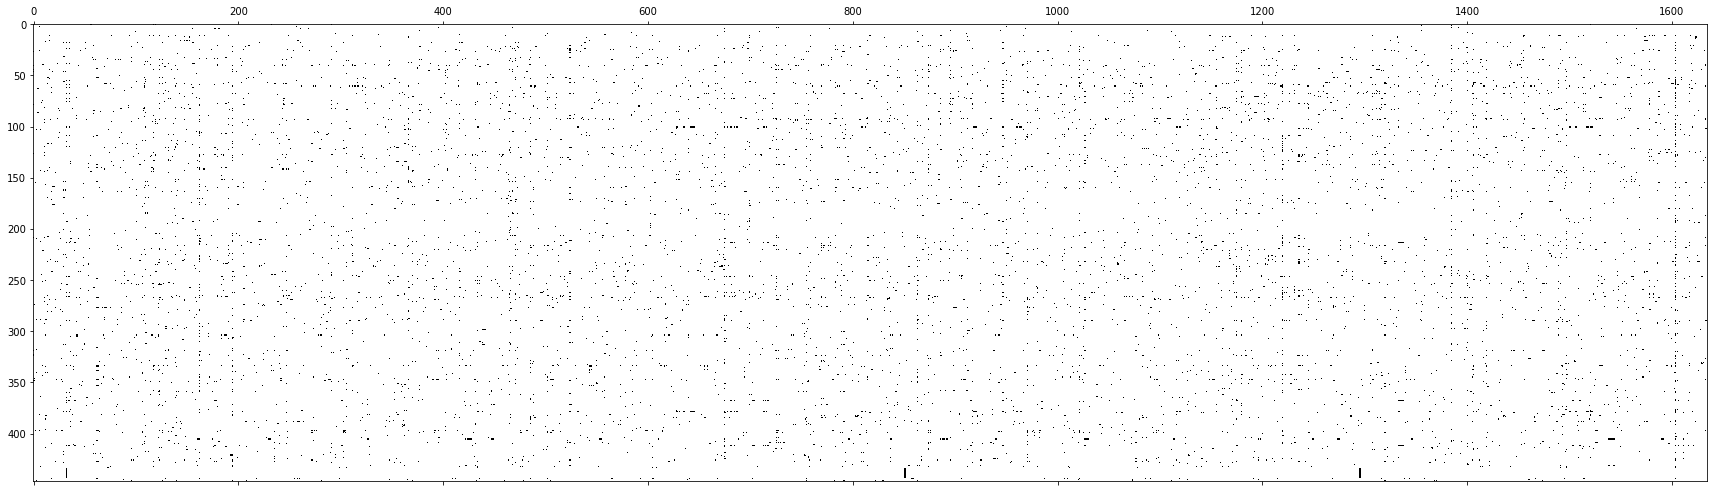

In [0]:
fig = plt.figure(figsize=(30,16))
plt.spy(sparse_df, figure=fig)

This looks like it is very very sparse. 

Let's look at the spread for the targets

(array([ 77.,   0., 224.,   0.,   0.,  70.,   0.,  63.,   0.,  13.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

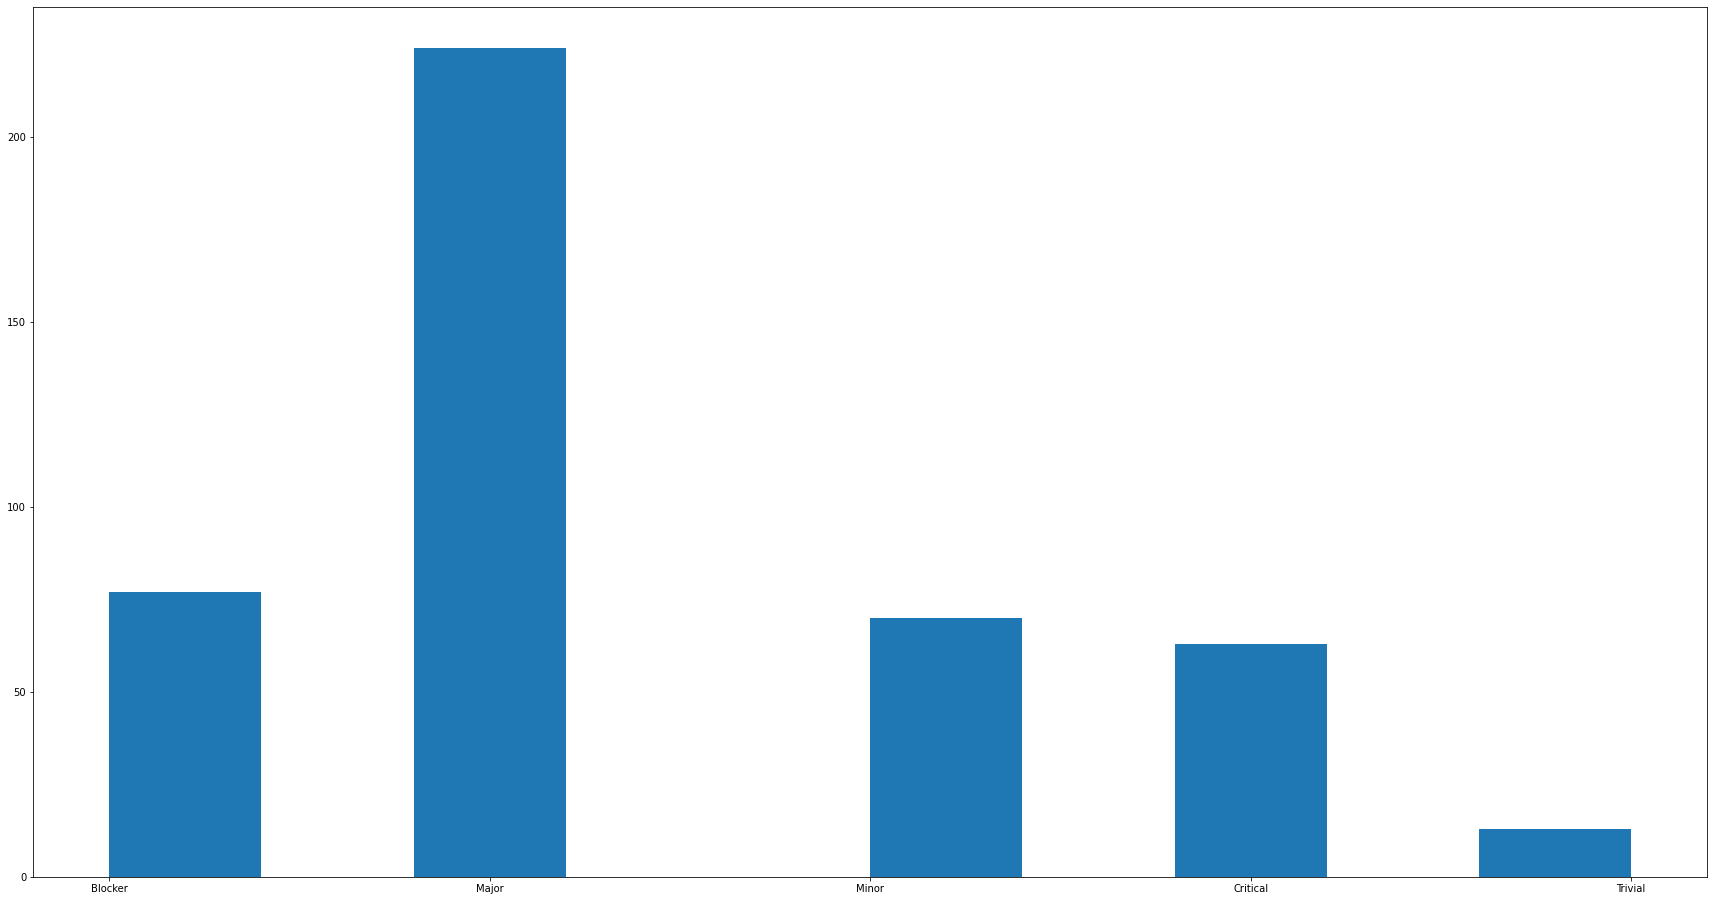

In [0]:
plt.figure(figsize=(30,16))
plt.hist(df.priority)

The data is highly biased to Major. However we only have ~ 400+ data points so we are still going to use it as is. 